In [188]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from scipy.stats import skew
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Перша частина. Здійсніть сегментацію бази користувачів-платників гри.

In [189]:
# Загрузка даних у pd.dataframe та перевірка на відсутність пропусків (null values)
data = pd.read_excel("_Junior Data Analyst.xlsx", sheet_name="Sheet2")
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   User_id      1000 non-null   int64  
 1   Year         1000 non-null   int64  
 2   Sex          1000 non-null   object 
 3   Payments     1000 non-null   int64  
 4   Money        1000 non-null   float64
 5   LifeTime     1000 non-null   float64
 6   LastLog      1000 non-null   float64
 7   LastPayment  1000 non-null   float64
 8   Sessions     1000 non-null   int64  
dtypes: float64(4), int64(4), object(1)
memory usage: 70.4+ KB


1. **(питання)** Які параметри ви оберете для сегментації? Чому?
**(відповідь)** Усі числові значення, окрім id користувача (id не дає нам жодної корисної інформації)

In [190]:
# Релевантні колонки для сегментації
params = ["Year", "Money", "Payments", "LifeTime", "LastLog", "LastPayment", "Sessions"]

user_data = data[params].copy()

In [191]:
# Нормалізація даних для кращої роботи алгоритму (K-Means)
scaler = StandardScaler()
user_data_scaled = scaler.fit_transform(user_data)

2. **(таска/питання)** Проведіть сегментацію. Визначте оптимальну, на вашу думку, кількість сегментів.
**(відповідь)** Визначимо оптимальну кількість сегментів за допомогою Elbow методу

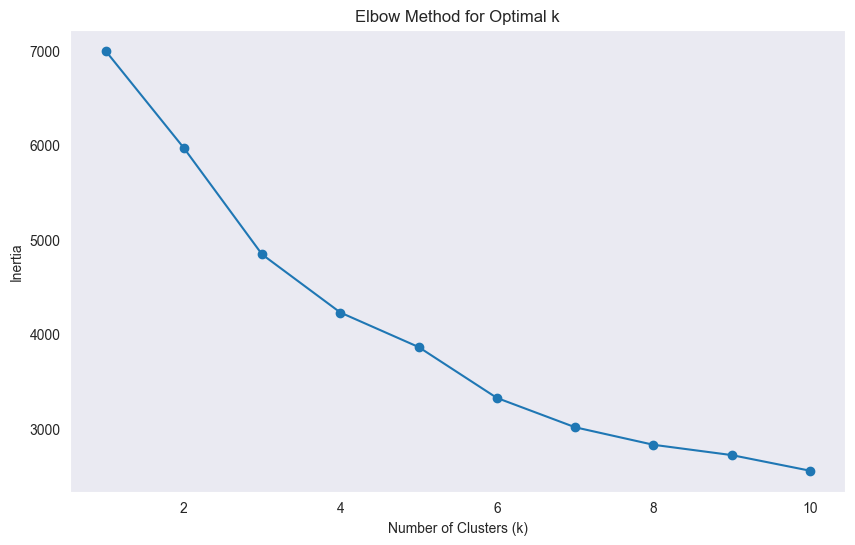

In [192]:
inertia = []
k_range = range(1, 11)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(user_data_scaled)
    inertia.append(kmeans.inertia_)
    
# Графік Elbow методу
plt.figure(figsize=(10, 6))
plt.plot(k_range, inertia, marker="o")
plt.title("Elbow Method for Optimal k")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Inertia")
plt.grid()
plt.show()

In [193]:
# Можна побачити, що після 4 кластерів досить повільно змінюється Inertia, беремо 4
kmeans = KMeans(n_clusters=4, random_state=42)
data["Cluster"] = kmeans.fit_predict(user_data_scaled)

# Виділимо корисні характеристики кожного сегменту кластера
cluster_summary = data.groupby("Cluster").agg({
    "User_id": "count",  # Number of users
    "Money": ["sum", "mean"],  # Total money spent and average
    "Payments": "mean",  # Average payments (number)
    "LifeTime": "mean",  # Average lifetime (days)
    "LastLog": "mean",   # Average days sin"e last login
    "LastPayment": "mean", # Average days since last payment
    "Sessions": "mean"    # Average sessions (days)
}).round(2).reset_index()

cluster_summary.columns = [
    "Cluster", "Number_of_Users", "Total_Money", 
    "Avg_Money", "Avg_Payments","Avg_LifeTime", 
    "Avg_LastLog", "Avg_LastPayment", "Avg_Sessions"
]

# Стовпець % витрат (Money) по всіх сегментах відносно всіх користувачів
total_money = cluster_summary["Total_Money"].sum()
cluster_summary["%_of_Total_Money"] = (
        (cluster_summary["Total_Money"] / total_money) * 100
).round(2)

# Інформація про кожен з 4 сегментів кластера
cluster_summary

,Cluster,Number_of_Users,Total_Money,Avg_Money,Avg_Payments,Avg_LifeTime,Avg_LastLog,Avg_LastPayment,Avg_Sessions,%_of_Total_Money
0,0,326,13089.74,40.15,4.92,369.23,15.64,223.15,135.23,9.72
1,1,571,53452.17,93.61,9.39,192.81,4.47,63.22,198.01,39.70
2,2,85,11084.58,130.41,9.60,421.65,2.71,179.36,1162.98,8.23
3,3,18,57027.62,3168.20,99.83,341.38,4.83,53.67,678.17,42.35


In [194]:
cluster_dfs = {}

# Записуємо кожен сегмент в окремий dataframe
for cluster in data["Cluster"].unique():
    cluster_dfs[cluster] = data[data["Cluster"] == cluster].copy()

# Тепер ми маємо 4 сегменти користувачів, які можемо обробити/вигрузити, якщо потрібно.
# Приклад сегменту під індексом 3, де ми маємо найбільших платників (найбільший avg Money).
cluster_dfs[3].head()

,User_id,Year,Sex,Payments,Money,LifeTime,LastLog,LastPayment,Sessions,Cluster
29,366,1991,male,139,694.61,833.545576,1.548843,10.559299,923,3
30,589,1905,male,87,4236.20,833.545576,1.548843,7.559299,1127,3
33,597,1974,female,164,2138.41,822.545576,9.548843,516.559299,1650,3
65,726,1974,female,96,6086.02,589.545576,12.548843,49.559299,2571,3
274,308,1961,female,87,1380.15,327.545576,1.548843,12.559299,892,3


### **Графік відношення "%Money" по всіх сегментах до "%Users" по всіх сегментах.**

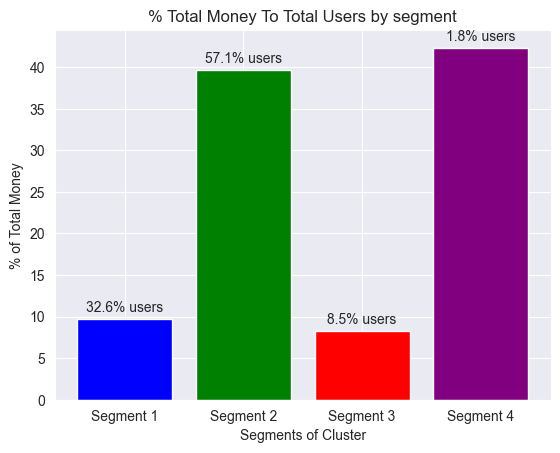

In [195]:
cluster_names = ["Segment 1", "Segment 2", "Segment 3", "Segment 4"]
percent_total_money = cluster_summary["%_of_Total_Money"]
percent_total_users = (
        (cluster_summary["Number_of_Users"] / 
         cluster_summary["Number_of_Users"].sum()) * 100
).round(2)

# Create the bars
fig, ax = plt.subplots()
bars = ax.bar(cluster_names, percent_total_money, color=["blue", "green", "red", "purple"])

# Add the percentage of total users as annotations
for i, bar in enumerate(bars):
    ax.annotate(f"{percent_total_users[i]}% users", 
                xy=(bar.get_x() + bar.get_width()/2, bar.get_height()), 
                xytext=(0, 3), 
                textcoords="offset points", 
                ha="center", 
                va="bottom")

# Set labels and title
ax.set_xlabel("Segments of Cluster")
ax.set_ylabel("% of Total Money")
ax.set_title("% Total Money To Total Users by segment")

plt.show()

3. **(питання)** Зробіть короткі висновки щодо аудиторії гравців.
4. **(питання)** Надайте короткий опис кожного із сегментів. Яку частку займають отримані сегменти за кількістю користувачів та сумою платежів?
5. **(питання)** Які подальші стратегії роботи з отриманими сегментами користувачів ви рекомендуєте?

**(відповідь)**:
* 1. **Перший сегмент (cluster_dfs[0])** - мало витрачають і мають середню зацікавленість / витрачений час.
% of Total Money spent: **9.72%**
% of total users: **32.6% користувачів** з dataframe (326/1000)
Avg. Money spent: **40.15**
Avg. Payments: **4.92** (number)
Avg. Sessions: **135.23** (number)
Avg. Last Activity: **15.64** (days)

**Опис:** Мабуть, найскладніший сегмент для залучення.
**Стратегія:** Складно сказати, чи це спрацює з даним сегментом, тому що такі користувачі не схильні платити, але на мою думку, можна спробувати заохочувати їх винагородами/бонусами в конкретні дні для заохочення частішого заходу/повернення на платформу, тому що мають "Avg. Last Activity: 15.64", що не є ідеалом.

* 2. **Другий сегмент (cluster_dfs[1])** - мають середні витрати та велику зацікавленість / витрачений час.
% of Total Money spent: **39.69%**
% of total users: **57.1% користувачів** з dataframe (571/1000).
Avg. Money spent: **93.61**
Avg. Payments: **9.39** (number)
Avg. Sessions: **198.01** (number)
Avg. Last Activity: **4.47** (days)

**Опис:** Користувачі з частим поверненням, більшими та частішими витратами.
**Стратегія:** Оскільки вони і так зацікавлені платформою, основною ціллю є збільшення їхніх витрат, наприклад бонусні кошти при поповненні балансу чи невеликі додаткові привілеї (швидкий вивід коштів тощо).

* 3. **Третій сегмент (cluster_dfs[2])** - великі витрати та дуже велика зацікавленість.
% of Total Money spent: **8.23%**
% of total users: **8.5% користувачів** з dataframe (85/1000)
Avg. Money spent: **130.41**
Avg. Payments: **9.60** (number)
Avg. Sessions: **1162.98** (number)
Avg. Last Activity: **2.71** (days)
 
**Опис:** Найвідданіші користувачі платформи (Avg. Sessions: 1162.98)
**Стратегія:** Цей сегмент повинен мати усі доступні привілеї платформи, наприклад, понижені чи взагалі скасовані відсотки комісії на вивід коштів з платформи, персональні бонусні програми з більшою винагородою, пріоритетна служба підтримки тощо.

* 4. **Четвертий сегмент (cluster_dfs[3]) - дуже великі витрати та велика зацікавленість.
% of Total Money spent: **42.35%**
% of total users: **1.8% користувачів** з dataframe (18/1000)
Avg. Money spent: **3168.20**
Avg. Payments: **99.83** (number)
Avg. Sessions: **678.17** (number)
Avg. Last Activity: **4.83** (days)

**Опис:** Дуже малий відсоток користувачів, але вони також одні з найвідданіших і платоспроможних, які генерують більше Money, ніж 57% користувачів другого сегменту.
**Стратегія:** Ми дуже зацікавлені в збереженні цих клієнтів, тому що незважаючи на їх невеликий розмір, вони генерують дуже велике ревеню, і компанія не зацікавлена в втраті таких гравців. Всі ті ж привілеї, що і попередня група відданих гравців, та найпріоритетніша та тактична служба підтримки для утримання гравців цього сегменту в грі.

# Друга частина. Детальніше дослідіть вік гравців.

**(таска/питання)** Розрахуйте середній вік гравця (як середнє арифметичне та медіану).

In [196]:
# Середній вік як середнє
user_data["Year"].mean().round(1)

np.float64(1959.8)

In [197]:
# Середній вік як медіана
user_data["Year"].median()

np.float64(1959.0)

**(таска/питання)** Гравці якого віку найчастіше зустрічаються в вибірці?

In [198]:
# Можна взяти моду по "Year"
user_data["Year"].mode()

0    1970
Name: Year, dtype: int64

In [199]:
# Або дістати усі одразу з інформацією про кількість
user_data["Year"].value_counts(sort=True).head()

Year
1970    79
1957    42
1954    38
1960    36
1962    36
Name: count, dtype: int64

**(таска/питання)** Чи є дані про вік гравців симетричними відносно середнього значення? Прокоментуйте результат.
**(відповідь)** Для цього скористаємося функцією skew() з бібліотеки scipy, яка показує відхилення від середнього значення. Якщо отримане значення ~= від -0.5 до 0.5, то вік гравців можна вважати симетричним. (ми отримали -0.15)

In [200]:
age_clean = user_data["Year"].copy()
age_skewness = skew(age_clean)
age_skewness.round(3)

np.float64(-0.156)

І в цілому, дивлячись на графік дистрибуції року народження гравців, видно, що він є симетричним.

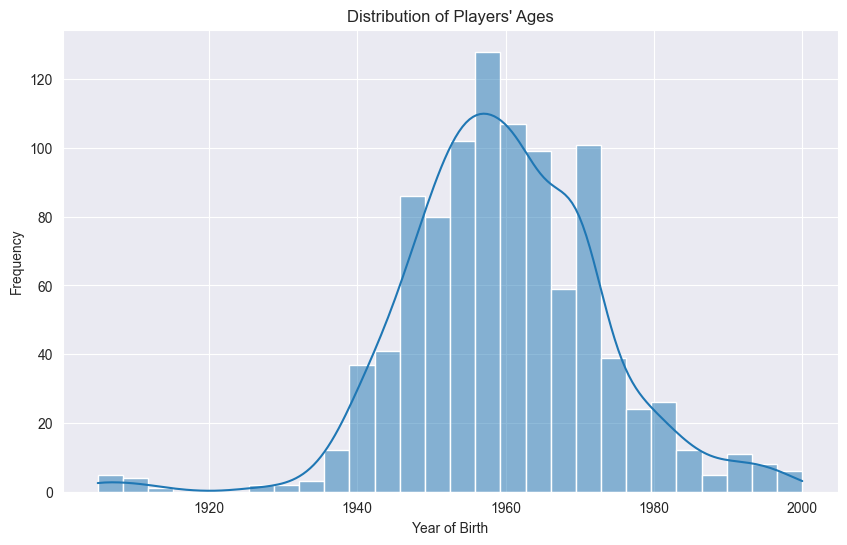

In [201]:
plt.figure(figsize=(10, 6))
sns.histplot(user_data["Year"], kde=True)
plt.xlabel("Year of Birth")
plt.ylabel("Frequency")
plt.title("Distribution of Players' Ages")
plt.show()

**(таска/питання)** Які значення віку гравців, на вашу думку, є аномальними? Чому? Запропонуйте правило відбору таких гравців.
**(відповідь)** Для більш точної відповіді спочатку знайдемо крайові значення віку гравців.

In [202]:
min_age = user_data["Year"].min()
max_age = user_data["Year"].max()
print(f"min_age: {min_age}, max_age: {max_age}")

min_age: 1905, max_age: 2000


Якщо ми припустимо, що легальний вік для гри на нашій платформі є 18 років, то час, коли був зібраний датафрейм, приблизно max_age + 18 (років) = 2018 рік. Це дає нам змогу зрозуміти, що 2018 - (90 років) = 1928 вік користувачів старше 90 років вважається винятком і може бути відфільтрований у подальшому аналізі. Зрозуміло, що гравці, наприклад, 1905 року (2018 - 1905 = 113 років), скоріше за все, вже не є нашими користувачами, і значення цього віку (< 1928) можна виключити.

Сходячи з цієї інформації, ми можемо перерахувати наскільки симетричними є дані про вік гравців відносно середнього значення. І побачимо, що значення все ще є симетричними, але з більшим відхиленням у сторону молодих гравців відносно середнього значення "Year".

In [203]:
age_not_higher_than_80 = user_data[user_data["Year"] > 1928]
age_skewness = skew(age_not_higher_than_80["Year"])
age_skewness.round(3)

np.float64(0.496)

Знаючи про цю аномалію, потрібно просто повторити усі розрахунки з фільтрацією по віку гравців, відкинувши усіх гравців, чий "Year" ~< 1928.

Підсумки 2-ї частини (до відсіяння аномалій):
* **Середній вік гравців: 58.2** (2018 - 1959.8)
* **Медіана віку гравців: 59** (2018 - 1959.0)
* **Найчастіше зустрічаються гравці з віком: 48** (2018 - 1970)**
* **Симетричність віку гравців: -0.15** (симетричні)